<h1 align='center'> Household Power Consumption Forecasting <h1>

<h2 align='right'> Euiyoung Chung <h2>
## Data Set Information:

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). <br><br>

### Notes: 
1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. <br>
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.<br><br>


## Attribute Information:

1.date: Date in format dd/mm/yyyy<br> 
2.time: time in format hh:mm:ss <br>
3.global_active_power: household global minute-averaged active power (in kilowatt) <br>
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) <br>
5.voltage: minute-averaged voltage (in volt) <br>
6.global_intensity: household global minute-averaged current intensity (in ampere) <br>
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). <br>
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. <br>
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.<br>

In [294]:
import warnings
warnings.filterwarnings("ignore")

# data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette('Paired', 10)

# tsa
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller

# ml
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
ls

household_electricity_consumption.ipynb
household_power_consumption.txt
practice.ipynb
sales-of-shampoo-over-a-three-ye.xls


## Data Import

In [295]:
df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']},
                index_col='datetime')

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


## Data Cleaning

In [234]:
df = df.replace('?', np.nan)

In [235]:
df = df.astype('float32')

In [236]:
df_mean = df['Global_active_power'].resample('W').mean()

In [237]:
df_mean = df_mean.interpolate(method='time')

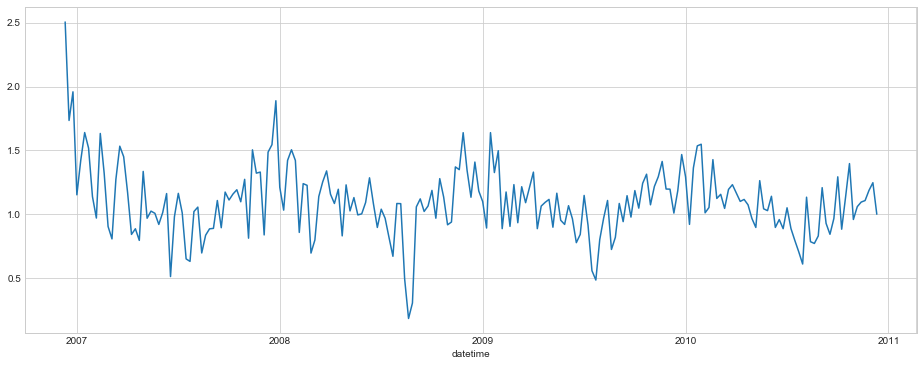

In [238]:
df_mean.plot(figsize=(16,6))

## Test Set Split

## Statinarity Checking

In [120]:
ad_test = adfuller(df_mean)

In [125]:
print('p-value of dickey-fuller test:', ad_test[1])

p-value of dickey-fuller test: 0.00029513420022084415


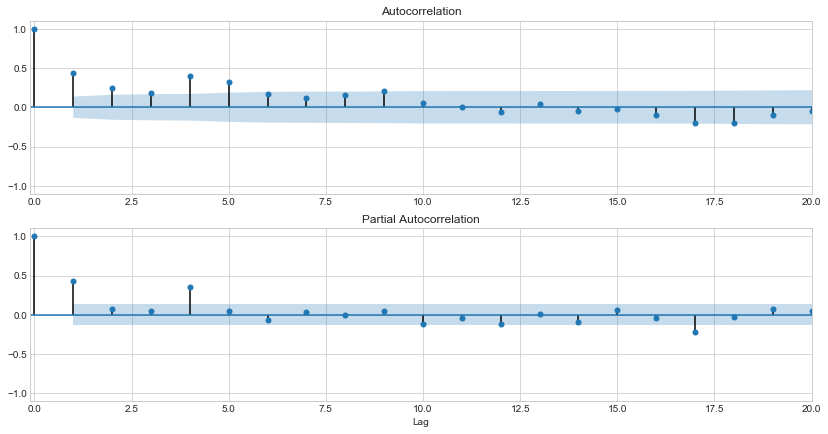

In [127]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))

sm.graphics.plot_acf(df_mean, lags=40, ax=ax1)
sm.graphics.plot_pacf(df_mean, lags=40, ax=ax2)

ax1.set_xlim(-0.1,20)
ax1.set_ylim(-1.1,1.1)

ax2.set_xlim(-0.1,20)
ax2.set_ylim(-1.1,1.1)
ax2.set_xlabel("Lag")

plt.show()

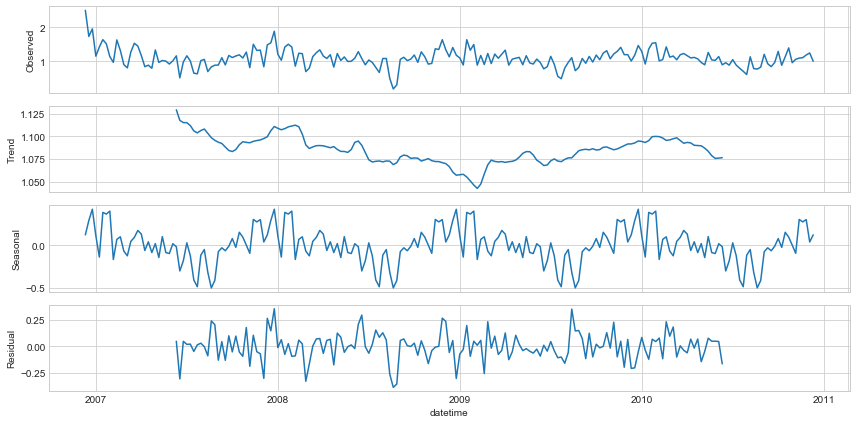

In [134]:
plt.rcParams['figure.figsize'] = 12, 6
decom = sm.seasonal_decompose(df_mean)
decom.plot()
plt.show()

## Detrending - 1. OLS fitting

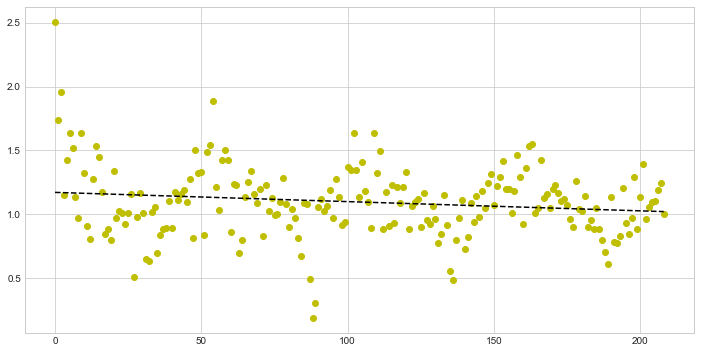

In [239]:
fit = np.polyfit(np.arange(df_mean.shape[0]), df_mean, deg=1)
fit_fn = np.poly1d(fit.squeeze())
plt.plot(np.arange(df_mean.shape[0]), df_mean, 'yo', 
         np.arange(df_mean.shape[0]), fit_fn(np.arange(df_mean.shape[0])), '--k')

In [240]:
trend = fit_fn(np.arange(df_mean.shape[0]))
df_detrend = df_mean - trend

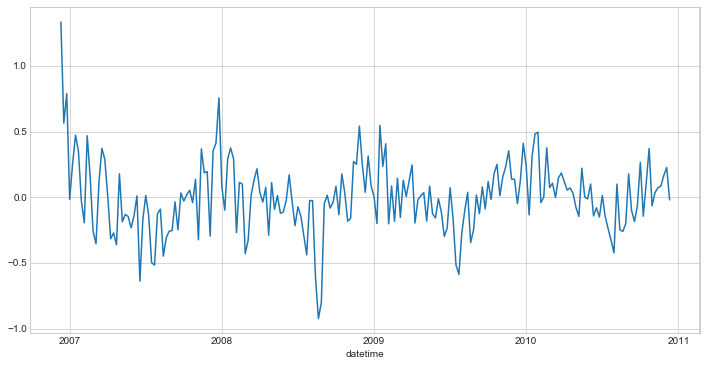

In [241]:
df_detrend.plot()

In [156]:
ad_test = adfuller(df_detrend)
ad_test

(-4.236067278000126,
 0.000572152035801519,
 3,
 205,
 {'1%': -3.4626576734812318,
  '10%': -2.5743412314098753,
  '5%': -2.8757444215841326},
 -52.05432323041964)

## Detrending - 2. Differencing

In [258]:
df_diff = df_mean.diff().dropna()

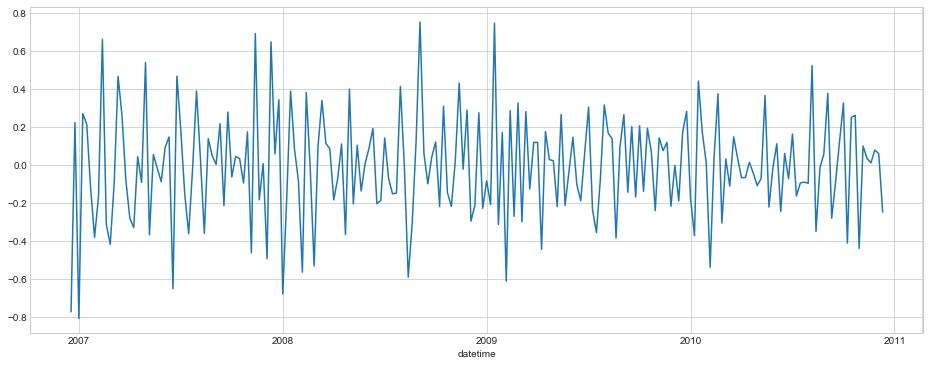

In [259]:
df_diff.plot(figsize=(16,6))

## Model1 - ARIMA fitting

In [157]:
sm.arma_order_select_ic(df_detrend)

{'bic':            0          1          2
 0  60.445638  31.440512  21.761371
 1  18.364658  15.359983  16.991552
 2  22.351350  17.827022  22.311773
 3  26.244047  19.058129  16.817013
 4  -1.597093   3.262600   8.271923, 'bic_min_order': (4, 0)}

In [242]:
mod = sm.SARIMAX(df_detrend, order = (4, 0, 0))
result = mod.fit()

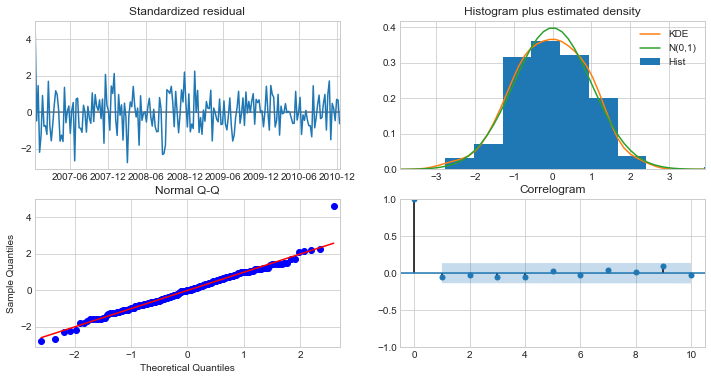

In [161]:
result.plot_diagnostics()
plt.show()

In [282]:
pred = result.predict(start="2010-05-23")

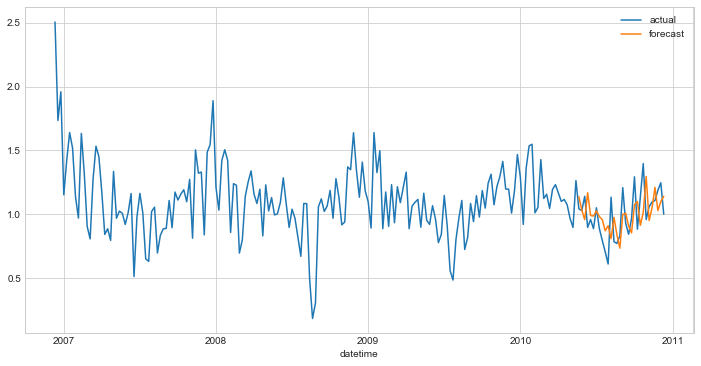

In [186]:
df_mean.plot(label='actual')
(pred+trend[-len(pred):]).plot(label='forecast')
plt.legend()
plt.show()

In [254]:
# Get forecast 500 steps ahead in future
pred_uc = result.get_forecast(steps=200)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

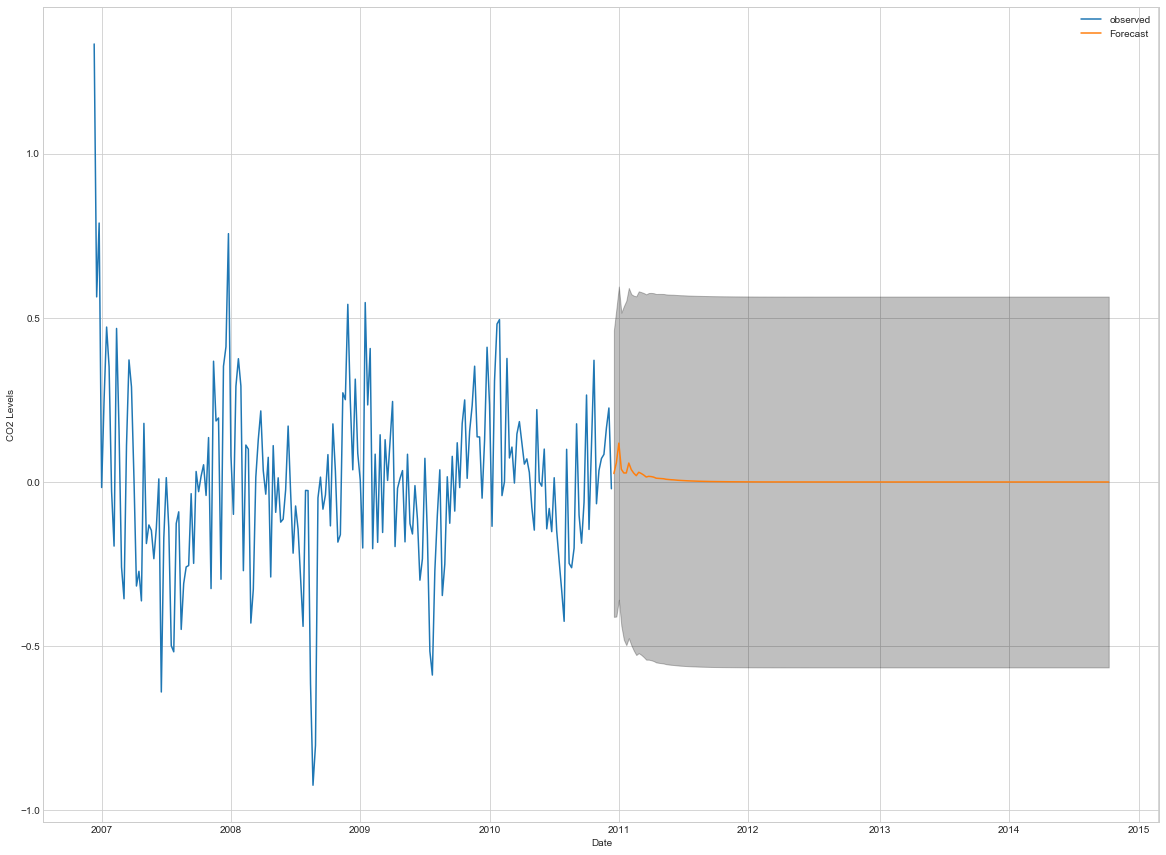

In [255]:
ax = (df_mean-trend).plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

## Model 1 - SARIMA fitting

In [262]:
mod = sm.SARIMAX(df_mean, order = (4, 1, 0), seasonal_order=(0, 1, 1, 4))
result = mod.fit()

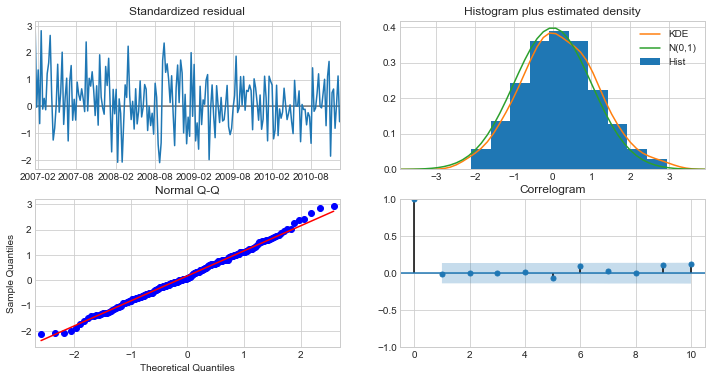

In [263]:
result.plot_diagnostics()
plt.show()

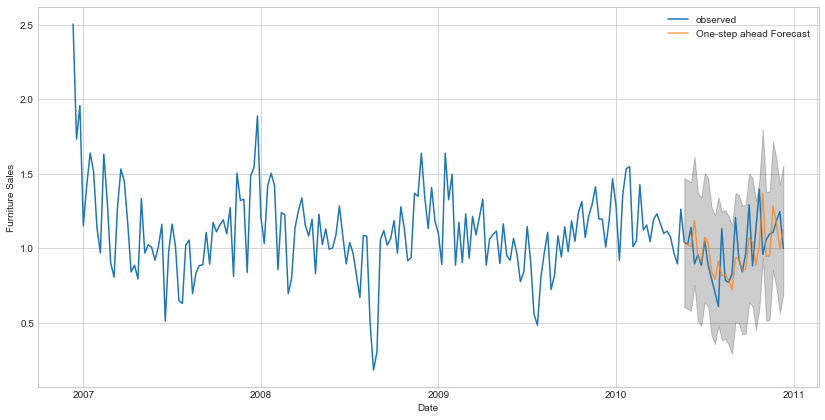

In [287]:
# Pred
pred = result.get_prediction(start=pd.to_datetime('2010-05-23'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_mean.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

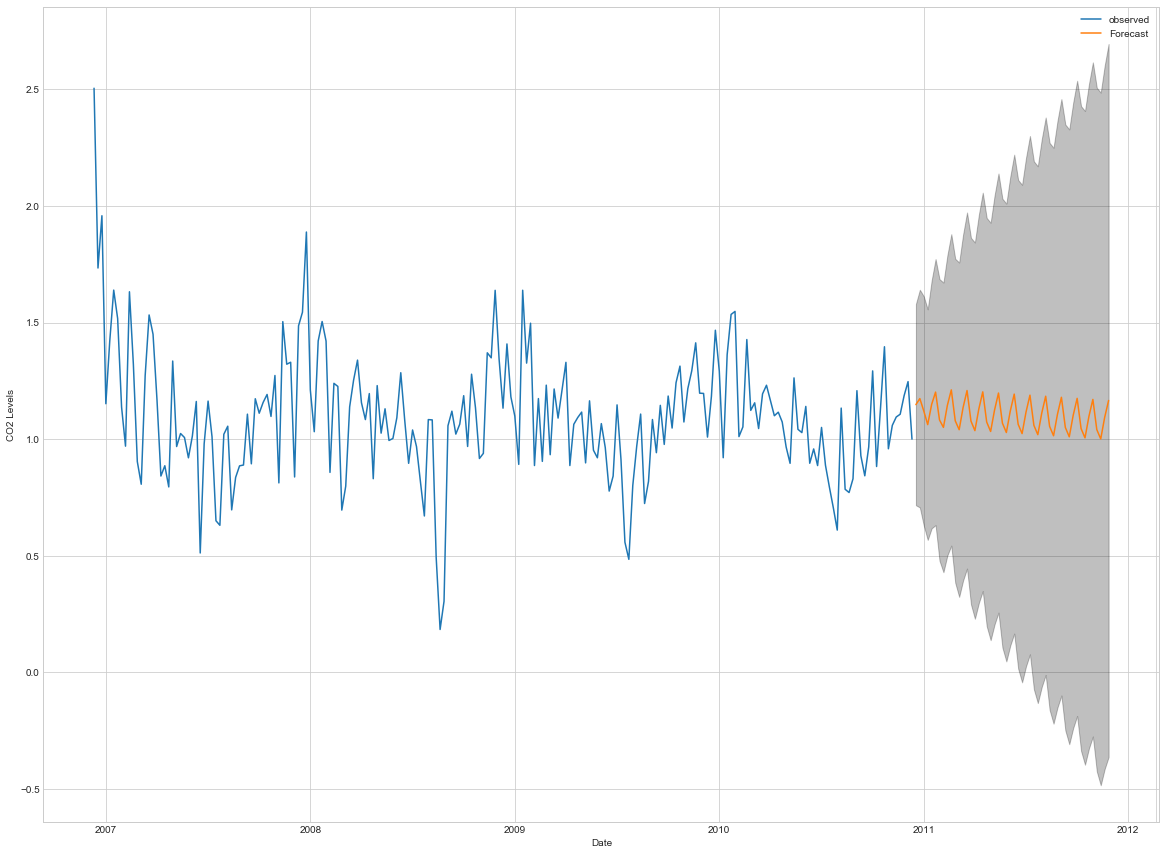

In [293]:
# Forecast
# Get forecast 500 steps ahead in future
pred_uc = result.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df_mean.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

## Model 2 - Machine Learning

In [219]:
df_month = df.resample('W').mean()

In [220]:
df_month['y'] = df_month['Global_active_power'].shift()

In [221]:
df_month.dropna(inplace=True)

In [222]:
X = df_month.iloc[:, :df_month.shape[1]-1].values
y = df_month['y'].values

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [224]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=100)

def metrics(cls, X_train, y_train, X_test, y_test, mae, mse):
    cls.fit(X_train, y_train)
    pred = cls.predict(X_test)
    
    res = []
    res.append(mae(y_test, pred))
    res.append(np.sqrt(mse(y_test, pred)))

    return res, pred
    
    
res, pred = metrics(rf, X_train, y_train, X_test, y_test, mean_absolute_error, mean_squared_error)

In [225]:
res

[0.17060179789932, 0.2063383012463669]

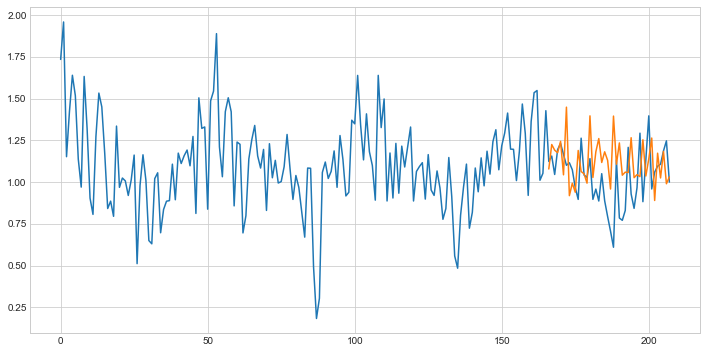

In [232]:
sns.lineplot(np.arange(X.shape[0]) , X[:,:1].squeeze())
sns.lineplot(np.arange(X_train.shape[0], X_train.shape[0]+len(pred)), pred.squeeze())

## Model 3 - Exponential Smoothing

In [336]:
df_mean = df.replace('?', np.nan).resample("W")

In [342]:
df_mean = df_mean.mean()

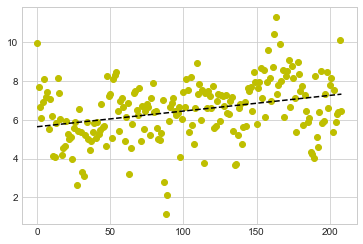

In [343]:
fit = np.polyfit(np.arange(df_mean.shape[0]), df_mean, deg=1)
fit_fn = np.poly1d(fit.squeeze())
plt.plot(np.arange(df_mean.shape[0]), df_mean, 'yo',
        np.arange(df_mean.shape[0]), fit_fn(np.arange(df_mean.shape[0])), '--k')

In [344]:
trend = fit_fn(np.arange(df_mean.shape[0])).reshape(-1, 1)

In [346]:
df_detrended = df_mean - trend